# To beat or not to beat: 1 drum

In [14]:
%load_ext tensorboard

In [15]:
rm -rf ./logs/

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import seaborn as sns
import pandas as pd
import random

sns.set()
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

# Data processing

## Dataset

Original read_midi function imported here, is from here: https://github.com/qsdfo/midi_to_numpy, however it was slightly adapted to function for this project.

## Data preprocessing

Split each bar of music into 32 vectors. First had 8, but then the nuance in the music was lost, see screenshot for comparison:

![Quantization](report/quantization_influence.png)


For example, the following bar from the MIDI data:

![MIDI Bar](report/midi_bar.png)

Gets turned into the a matrix (heatmap of values):

![MIDI Bar Matrix](report/midi_bar_matrix.png)

# Configuration

In [2]:
# 36	Kick
# 38	Snare (Head)
# 40	Snare (Rim)
# 37	Snare X-Stick
# 48	Tom 1
# 50	Tom 1 (Rim)
# 45	Tom 2
# 47	Tom 2 (Rim)
# 43	Tom 3 (Head)
# 58	Tom 3 (Rim)
# 46	HH Open (Bow)
# 26	HH Open (Edge)
# 42	HH Closed (Bow)
# 22	HH Closed (Edge)
# 44	HH Pedal
# 49	Crash 1 (Bow)
# 55	Crash 1 (Edge)
# 57	Crash 2 (Bow)
# 52	Crash 2 (Edge)
# 51	Ride (Bow)
# 59	Ride (Edge)
# 53	Ride (Bell)

DRUM_INDEXES = [36]
QUANTIZE = 32  # Divisions per beat

# How big should the training windows be?
WINDOW_BEAT_COUNT = 4
WINDOW_WIDTH = QUANTIZE * WINDOW_BEAT_COUNT

# Count instruments in songs

In [99]:
import read_midi
import write_midi
import utils
from IPython.display import clear_output

count_matrix = np.empty((128,))

count = 0

df = pd.DataFrame()

with open('groove/info.csv', newline='') as csvfile:
    groove_info = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in groove_info:
        count += 1
        try:
            time_signature = row[6]
            beat_type = row[5]
            style = row[3]
            # Only keep 4-4 beats, these are the most common. Also having other beats in here would
            # make stuff more complicated for the NN to learn.
            if time_signature == "4-4" and style == "rock":
                # Create vector with data
                bpm = row[4]
                filepath = row[7]

                # Read the midi file using the original code
                file = read_midi.Read_midi("groove/" + filepath, QUANTIZE).read_file()
                # Convert it into a matrix
                matrix = utils.dict_to_matrix(file)

                count_matrix = np.add(count_matrix, matrix.sum(axis=0))

        except Exception as e:
            print(e)


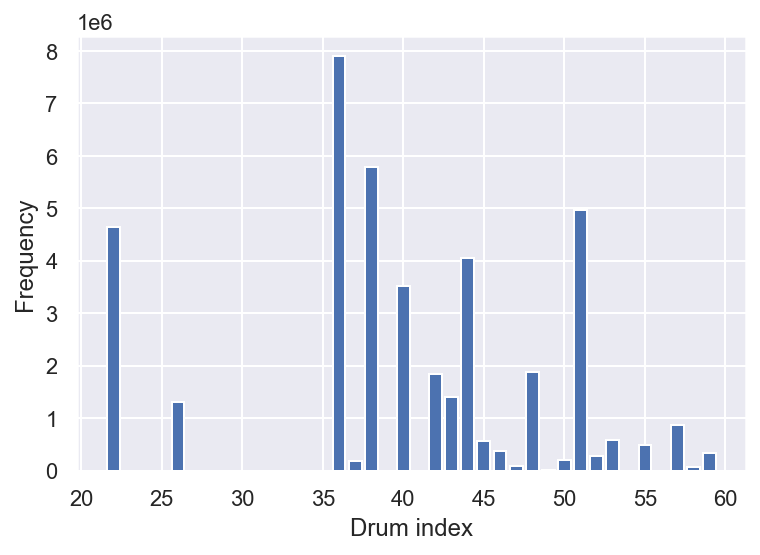

In [116]:
b = np.expand_dims(count_matrix, axis=0)
ax = plt.bar(x=range(22,60), height=b[0][22:60])
plt.ylabel('Frequency')
plt.xlabel('Drum index')
# plt.show()
plt.savefig('report/drum_count.png')
plt.savefig('report/drum_count.pdf')
plt.savefig('report/drum_count.svg')

# Turning MIDI into data.
## \/ DO NOT RUN \/. Nothing will break, but regenerating the data takes days.

In [2]:
import read_midi
import write_midi
import utils
from IPython.display import clear_output

count_matrix = np.empty((128,))

count = 0

df = pd.DataFrame()

with open('groove/info.csv', newline='') as csvfile:
    groove_info = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in groove_info:
        count += 1
        try:
            time_signature = row[6]
            beat_type = row[5]
            style = row[3]
            # Only keep 4-4 beats, these are the most common. Also having other beats in here would
            # make stuff more complicated for the NN to learn.
            if time_signature == "4-4" and style == "rock":
                # Create vector with data
                bpm = row[4]
                filepath = row[7]

                # Read the midi file using the original code
                file = read_midi.Read_midi("groove/" + filepath, QUANTIZE).read_file()
                # Convert it into a matrix
                matrix = utils.dict_to_matrix(file)

                count_matrix = np.add(count_matrix, matrix.sum(axis=0))

                if matrix.sum(axis=0)[38] == 0:
                    print("Empty, skipping")
                    continue

                # Only get the drum-type pitches (instruments), we don't care for the other pitches.
                # As per the drum mapping information for the original dataset
                # (https://magenta.tensorflow.org/datasets/groove), everything but these 22 pitches are removed
                # from the matrix. This reduces the amount of columns from 128 to 22, removing a lot of useless data
                only_drums_matrix = matrix[:, DRUM_INDEXES]

                # Normalize values to be 0 or 1.
                only_drums_matrix[only_drums_matrix > 0] = 1

                song_df = pd.DataFrame()
                window_count = only_drums_matrix.shape[0] - WINDOW_WIDTH
                for i in range(0, window_count):
                    clear_output(wait=True)
                    print("Starting " + row[7])
                    print("Song", count, "of 1151")
                    print("Slice", i, "of", window_count)
                    window = only_drums_matrix[range(i, i+WINDOW_WIDTH), :]
                    # Turn this matrix into a flat vector
                    # Transpose it, so the last part of the vector will consist of the last "slice" of music
                    # So this can then be used for training
                    # Otherwise the last slice will consist of the last instrument.
                    transposed = window.transpose()
                    only_drums_vector = transposed.flatten(order='C')
                    song_df = pd.concat([song_df, pd.DataFrame(only_drums_vector).T])
                    df = pd.concat([df, pd.DataFrame(only_drums_vector).T])
                    # Matrix for nice chart
                    # ax = sns.heatmap(transposed, linewidth=0, cmap="viridis")
                    # plt.show()
                song_df.to_csv('data/songs/4beat-' + filepath.replace("/", "---").replace(".mid", "") + '.csv')

        except Exception as e:
            print(e)

    df.to_csv('data/4beat-rock.csv')

print("Saved")

Starting drummer2/session2/15_rock_130_beat_4-4.mid
Song 1151 of 1151
Slice 128 of 129
Saved


# Load previously generated data
Loading the data from the CSV file here.
After the previous step, further processing was done to remove all zero vectors from the CSV, and the data was shuffled.

In [3]:
df = pd.read_csv('data/4beat-rock-no-zeros-shuffled.csv')
df = df.iloc[: , 1:] # Remove first column
np.where(pd.isnull(df))
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,...,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000,631011.000000
mean,0.163263,0.163235,0.163170,0.163078,0.162994,0.162924,0.162896,0.162896,0.162927,0.162965,...,0.163378,0.163358,0.163347,0.163330,0.163325,0.163370,0.163441,0.163528,0.163610,0.163661
std,0.369606,0.369580,0.369521,0.369437,0.369360,0.369297,0.369271,0.369271,0.369300,0.369334,...,0.369710,0.369693,0.369683,0.369667,0.369662,0.369703,0.369768,0.369847,0.369922,0.369968
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Covert windows into training data
Here we load the dataset. First we split it into 80% training data, 20% validation data.

Then, for each window of length 128, we take the first 127 values (the labels) and the remaining last value (the next timestep we want it to predict).

In [5]:
N_TRAIN = int(round(len(df) * 0.8))
N_VALIDATION = int(len(df) - N_TRAIN)

BATCH_SIZE = 1000

x = df.iloc[: , 0:-1] # Features
y = df.iloc[: , -1] # Labels

dataset = tf.data.Dataset.from_tensor_slices((x, y))

# print(dataset)
# for x, y in dataset:
#     print(x, y)
#     break

val_dataset = dataset.take(N_VALIDATION).cache()
train_dataset = dataset.skip(N_VALIDATION).take(N_TRAIN).cache()

# Create batches
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(2)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(2)

print("Training points:", N_TRAIN)
print("Validation points:", N_VALIDATION)


Training points: 504809
Validation points: 126202


# The neural network

In [32]:
net_ker = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(units=1)
])

net_ker.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=['mse', 'accuracy']
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=20)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

# Launch TensorBoard

In [ ]:
%tensorboard --logdir logs/train

# Training

In [ ]:
history = net_ker.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=150,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback, tensorboard_callback],
)

# Plot the data

In [ ]:
# summarize history for loss
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the plot

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
name = input()
plt.savefig('report/error_models/' + name + '.png')
plt.savefig('report/error_models/' + name + '.pdf')
plt.savefig('report/error_models/' + name + '.svg')

# Have the NN generate a song

Finally, now that the NN is trained, we can generate a song!

Press play, and an updated MIDI file called `test-song.mid` will appear. Also, some nice graphs for inspecting the song are created.

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


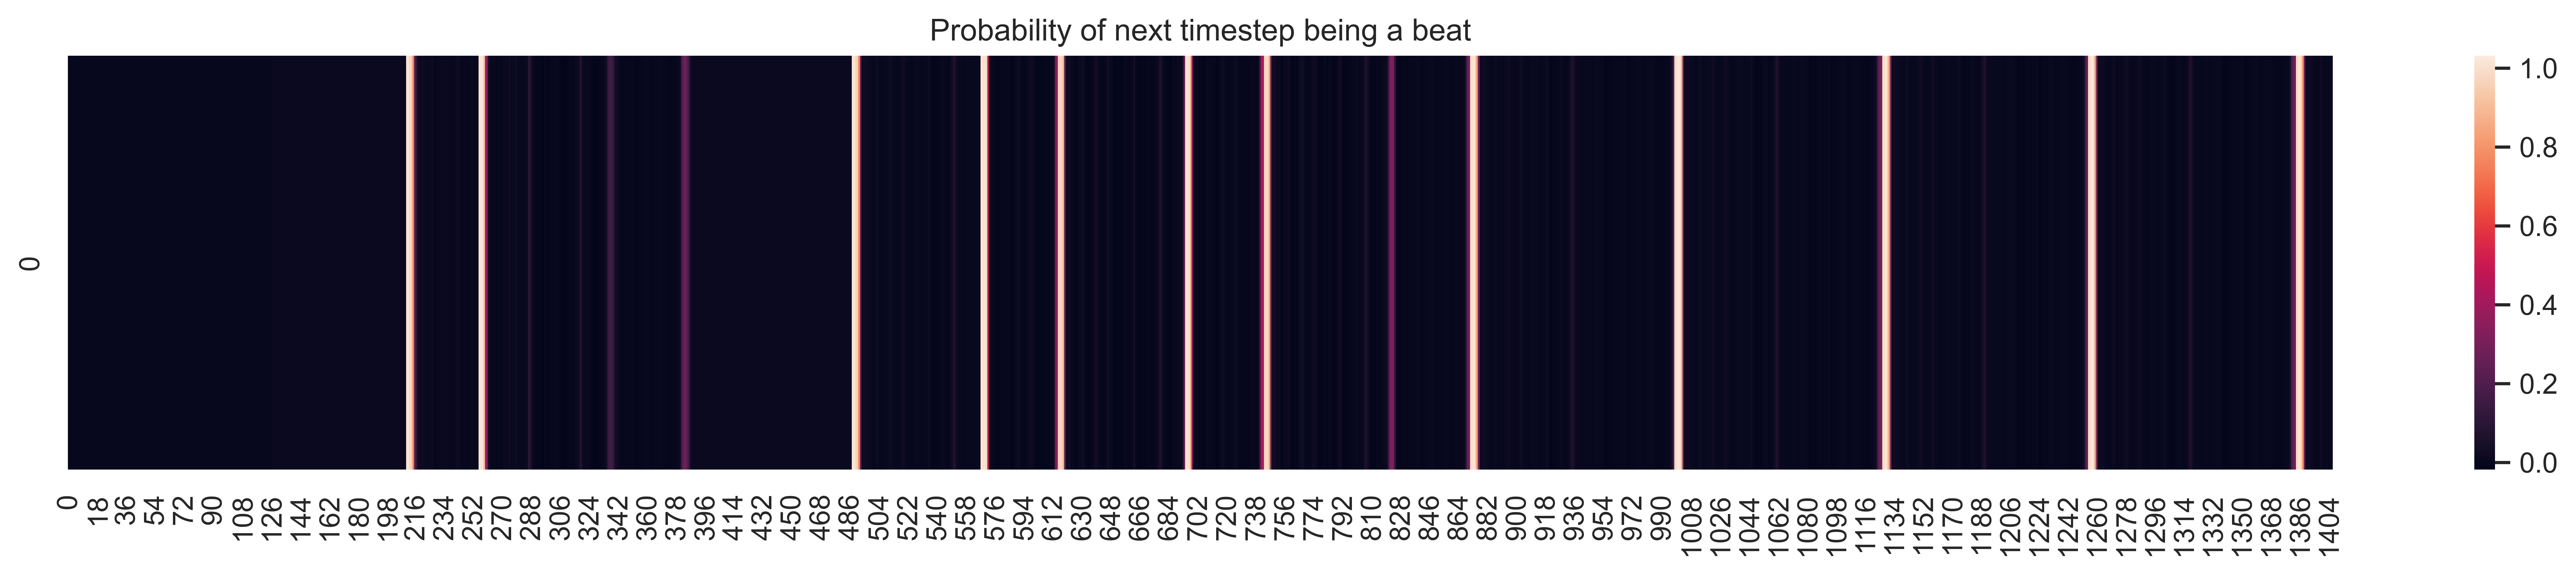

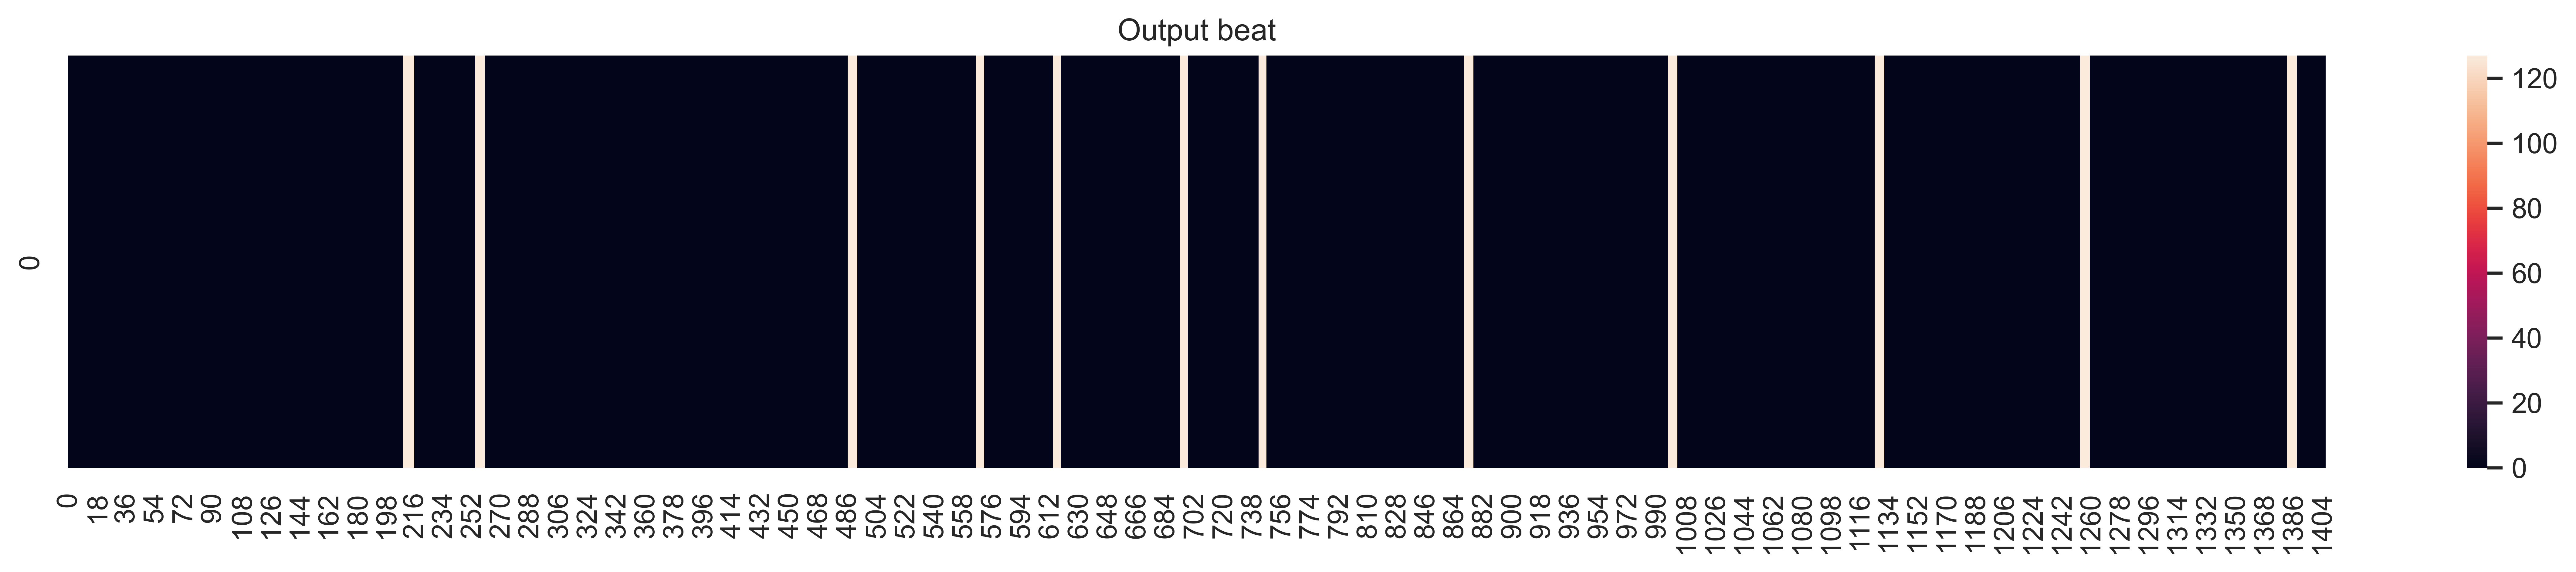

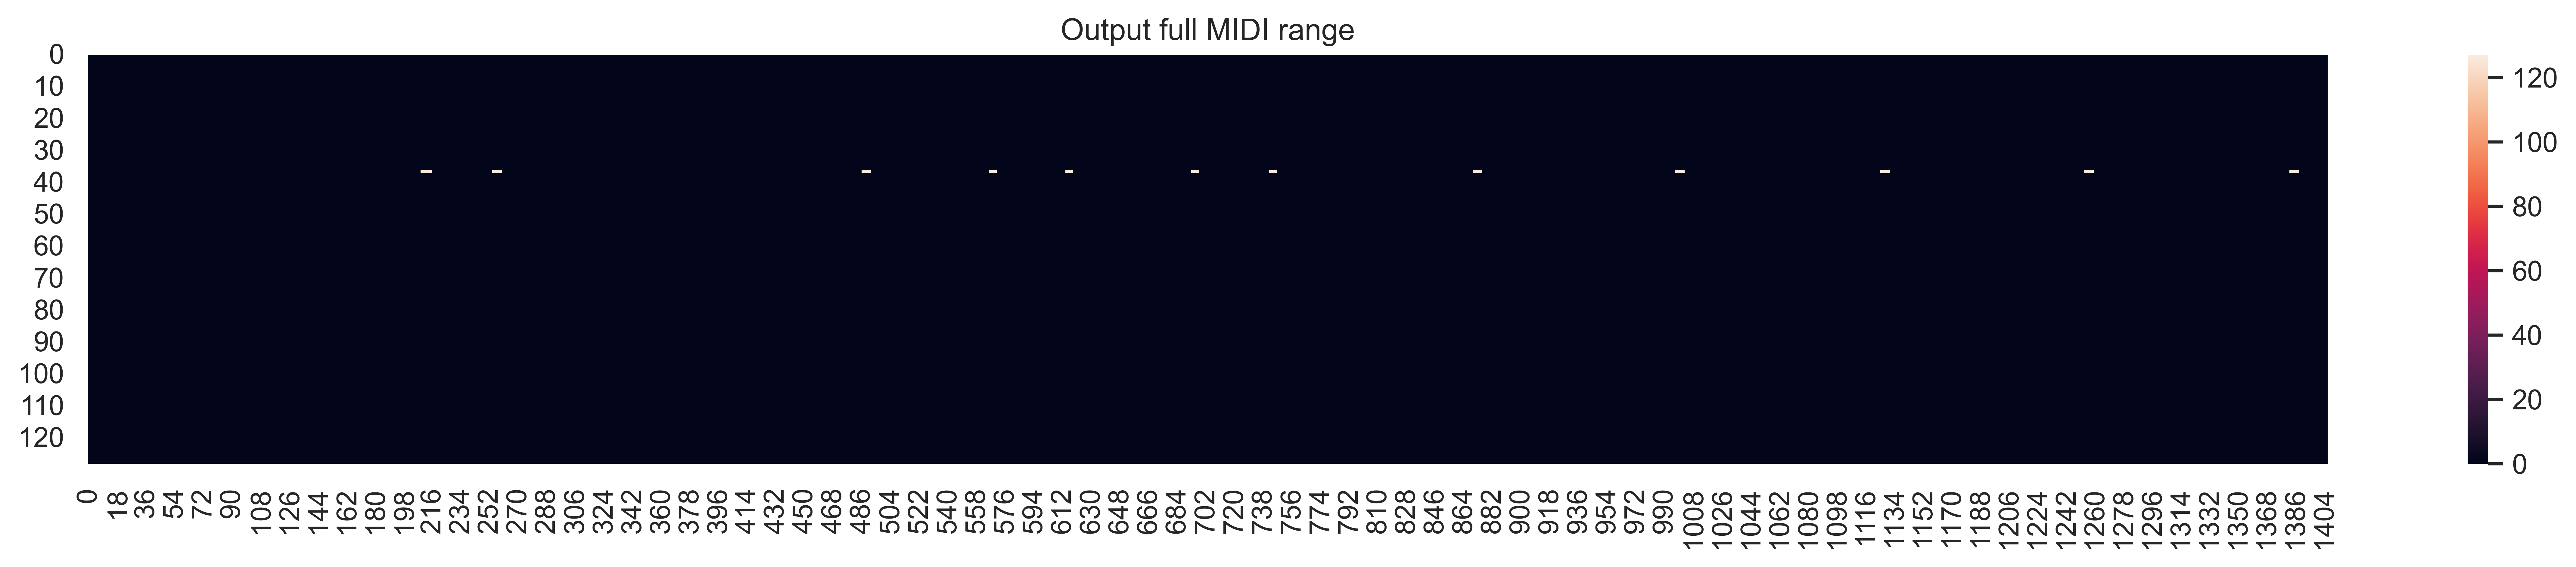

In [38]:
import utils
import write_midi

OUTPUT_BPM = 120

# -------
# Network generating a song

loop_steps = round(QUANTIZE * (120 / 3)) # 20 second beat
window = np.zeros((127))
only_drums_vector = np.zeros((127))

raw_output_only_drums_vector = np.zeros((127))

for x in range(loop_steps):
    expanded = np.expand_dims(window, axis=0)
    predictions = net_ker(expanded)
    window = np.roll(window, -1)

    prediction = 1 if random.random() <  predictions.numpy()[0][0] else 0

    window[-1] = round(prediction)
    only_drums_vector = np.append(only_drums_vector, [prediction])
    raw_output_only_drums_vector = np.append(raw_output_only_drums_vector, [predictions.numpy()[0][0]])


# --------
# Turning the generated song back into MIDI so we can play it

# Read the vector and turn it back into midi
input_only_drums_matrix = np.reshape(only_drums_vector, (int(only_drums_vector.shape[0] / len(DRUM_INDEXES)), len(DRUM_INDEXES)), order='C')


raw_output_input_only_drums_matrix = np.reshape(raw_output_only_drums_vector, (int(raw_output_only_drums_vector.shape[0] / len(DRUM_INDEXES)), len(DRUM_INDEXES)), order='C')
# We get the 22 column matrix again, but to turn it back into midi we need all 128 columns back
# So we create an empty matrix of the correct 128 column size, and replace our columns
# in that matrix. That way we get a matrix with zeros everywhere except for our pitches.
new_midi_matrix = np.zeros((input_only_drums_matrix.shape[0], 128), dtype=np.int16)
for i in range(len(DRUM_INDEXES)):
    new_column = DRUM_INDEXES[i]
    print(new_midi_matrix[:,new_column])
    print(input_only_drums_matrix[:,i])
    new_midi_matrix[:,new_column] = input_only_drums_matrix[:,i]

input_only_drums_matrix = input_only_drums_matrix * 127
new_midi_matrix = new_midi_matrix * 127

plt.figure(figsize = (20,3))
ax = sns.heatmap(raw_output_input_only_drums_matrix.transpose(), linewidth=0, cmap="rocket").set(title='Probability of next timestep being a beat')
plt.show()

plt.figure(figsize = (20,3))
ax = sns.heatmap(input_only_drums_matrix.transpose(), linewidth=0, cmap="rocket").set(title='Output beat')
plt.show()

plt.figure(figsize = (20,3))
ax = sns.heatmap(new_midi_matrix.transpose(), linewidth=0, cmap="rocket").set(title='Output full MIDI range')
plt.show()

# Write our new midi matrix to a file, that we can then play!
new_file = utils.matrix_to_dict(new_midi_matrix)
write_midi.write_midi(new_file, QUANTIZE, "test-song.mid", int(OUTPUT_BPM))

In [ ]:
plt.figure(figsize = (12,2))
ax = sns.heatmap(raw_output_input_only_drums_matrix.transpose(), linewidth=0, cmap="rocket", yticklabels=False, cbar_kws={'label': 'Probability'}).set(xlabel='Timestep')
# ax=plt.gca()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(32))
plt.savefig('report/small-1-inst-song-3-probability.png',bbox_inches='tight')

plt.figure(figsize = (12,2))
ax = sns.heatmap(input_only_drums_matrix.transpose(), linewidth=0, cmap="rocket", yticklabels=False, cbar_kws={'label': 'Velocity'}).set(xlabel='Timestep')
plt.savefig('report/small-1-inst-song-3-beat.png',bbox_inches='tight')

plt.figure(figsize = (12,2))
ax = sns.heatmap(new_midi_matrix.transpose(), linewidth=0, cmap="rocket", yticklabels=False, cbar_kws={'label': 'Velocity'}).set(xlabel='Timestep')
plt.savefig('report/small-1-inst-song-3-midi.png',bbox_inches='tight')